In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [2]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction
def gauss_dist(norms, alpha, c, b):
    # Gaussian distance function
    return c*np.exp(-alpha*(norms**2)) + b

In [3]:
def attraction_to_flower_gaussian(attraction_differences, distance, distance_norms, alpha=1, c=1, b=0):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    net_attraction = (velocity_unit_vector * gauss_dist(distance_norms, alpha, c, b)) / (1 + attraction_norm)

    return net_attraction


In [4]:
def attraction_to_flower_inverse(attraction_differences, distance, distance_norms, alpha=1, c=1, b=0):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    net_attraction = (velocity_unit_vector * (1/distance_norms)) / (1 + attraction_norm)

    return net_attraction


In [21]:
flower_qnty = 10
bee_qnty = 5
max_attraction = 4
max_position = 200
features = 5
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

beehive_position = np.array([max_position/2, max_position/2]).reshape(-1, 1)

print(flower_positions.shape)
print(beehive_position.shape)
print(bee_positions.shape)

distance = beehive_position[:, np.newaxis, :] - bee_positions[:, :, np.newaxis]
print(flower_positions[:, np.newaxis, :].shape)
print(bee_positions[:, :, np.newaxis].shape)

print(distance.shape)

(2, 10)
(2, 1)
(2, 5)
(2, 1, 10)
(2, 5, 1)
(2, 5, 1)


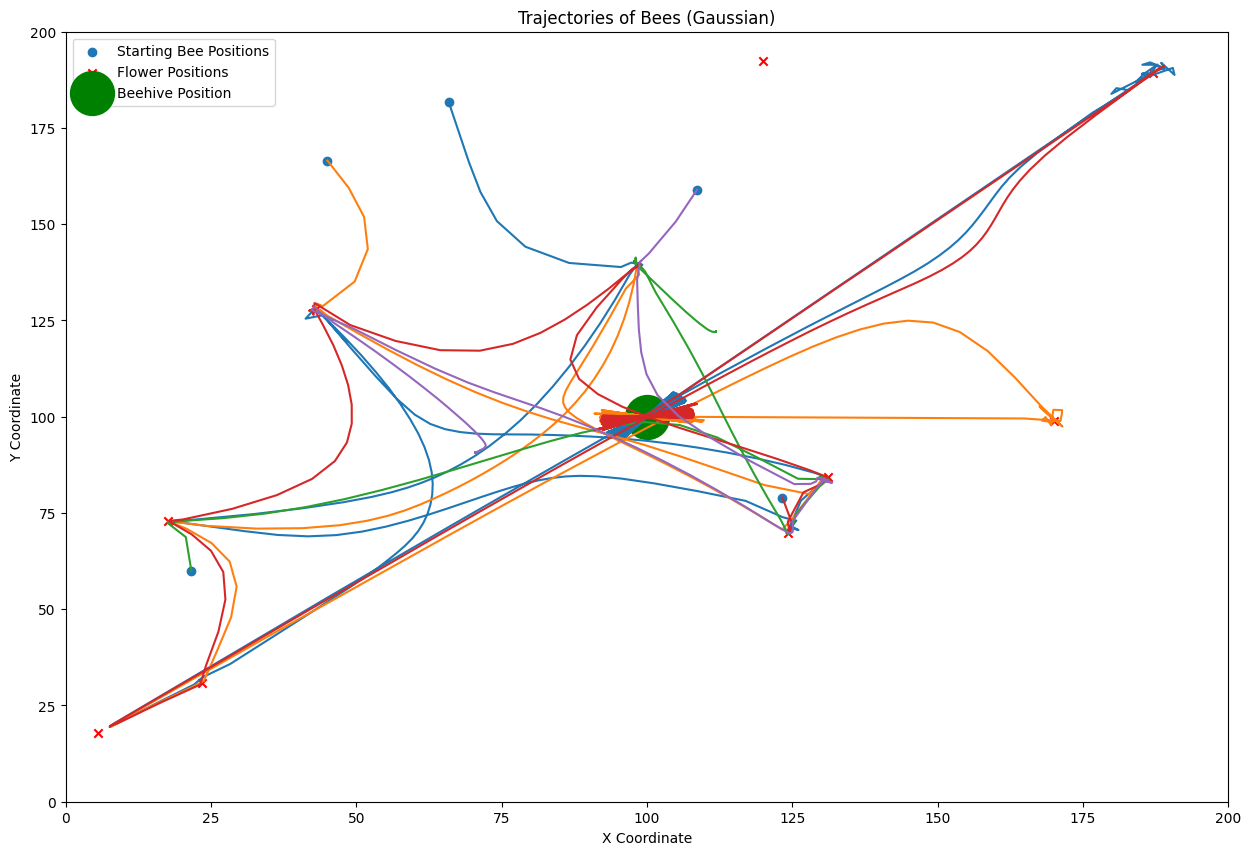

In [67]:
flower_qnty = 10
bee_qnty = 5
max_attraction = 4
max_position = 200
features = 5
flowers_to_visit = int(flower_qnty / 3)
# flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
# bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
# bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
# flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

beehive_position = np.array([max_position/2, max_position/2]).reshape(-1, 1)

# Define parameters and initial conditions
t_steps = 1000
t_final = t_steps / 10
t_vals = np.linspace(0,t_final,t_steps)
nu = .5 * max_position  # Parameter for the ODE
xsi = 0.2  # Parameter for the ODE
alpha = 0.5 / max_position  # Parameter for the ODE
c = 10
b = 0.5
eps = 0.6  # Proximity threshold for flower visitation

seconds_at_flower =  3
flowers_to_visit = 8

def beehive(t, x, activate):

    scaling_factor = (flower_qnty + 1)**2
    beehive_distance = beehive_position[:, np.newaxis, :] - x[:, :, np.newaxis]
    beehive_direction = (beehive_distance)
    return (beehive_direction * scaling_factor).squeeze() * activate


attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
# attraction_differences = np.zeros_like(attraction_differences)
T_i = np.ones((bee_qnty, flower_qnty))
def ode(t, x_flat, T_i):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))
    distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_norms = np.linalg.norm(distance, axis=0)

    T_i -= (distance_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0


    flowers_visited = flower_qnty - np.sum(gamma, axis=1)

    attractors = attraction_to_flower_gaussian(attraction_differences, distance, distance_norms, alpha, c, b)

    attractors = attractors * gamma

    combined_vector = attractors.sum(axis=2)
    
    velocity = (nu * (combined_vector + beehive(t, x, flowers_visited >= flowers_to_visit))) / (xsi + np.linalg.norm(combined_vector + beehive(t, x, flowers_visited >= flowers_to_visit), axis=0))

    # add noise
    velocity += np.random.normal(0, 0.1, velocity.shape)

    # if bee's are stuck, move them randomly
    # stuck = np.linalg.norm(velocity, axis=0) < 0.1
    # velocity[:, stuck] = np.random.normal(0, 1, velocity[:, stuck].shape)

    # return the velocity for each bee
    return velocity.flatten()


# ode(0, bee_positions, T_i)

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(15, 10))



for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y)

plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Bee Positions')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

# plot the beehive as large green dot
plt.scatter(beehive_position[0, :], beehive_position[1, :], marker='o', color='g', s=1000,label='Beehive Position')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees (Gaussian)')
plt.xlim(0,max_position)
plt.ylim(0,max_position)
plt.legend()

plt.show()



# T_i = np.ones((bee_qnty, flower_qnty))
# def ode(t, x_flat, T_i):

#     # Reshape x back to its original 2D shape
#     x = x_flat.reshape((2, -1))
#     distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
#     distance_norms = np.linalg.norm(distance, axis=0)

#     T_i -= (distance_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))
#     gamma = T_i > 0

#     attractors = attraction_to_flower_inverse(attraction_differences, distance, distance_norms, alpha, c, b)

#     attractors = attractors*gamma

#     combined_vector = attractors.sum(axis=2)
    
#     velocity = (nu * combined_vector) / (xsi + np.linalg.norm(combined_vector, axis=0))

#     # return the velocity for each bee
#     return velocity.flatten()


# # ode(0, bee_positions, T_i)

# solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# # Extract the solution
# trajectories = solution.y

# # Reshape the trajectories to (2, num_bees, num_time_points)
# num_bees = bee_qnty
# num_time_points = trajectories.shape[1]
# trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

# plt.figure(figsize=(10, 6))



# for i in range(num_bees):
#     # Extracting the x and y coordinates of the i-th bee
#     x = trajectories_reshaped[0, i, :]
#     y = trajectories_reshaped[1, i, :]
#     plt.plot(x, y)

# plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Bee Positions')
# # plot the flowers
# plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('Trajectories of Bees (Inverse)')
# plt.xlim(-5,max_position + 5)
# plt.ylim(-5,max_position + 5)
# plt.legend()

# plt.show()



In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, max_position + 5)
ax.set_ylim(-5, max_position + 5)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Trajectories of Bees (Gaussian)')

bee_lines = [ax.plot([], [])[0] for i in range(num_bees)]

ax.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Bee Positions')
ax.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')
ax.scatter(beehive_position[0, :], beehive_position[1, :], marker='o', color='y', s=100,label='Beehive Position')
ax.legend()

def animate(frame):
    # Update the lines for each bee
    for i, line in enumerate(bee_lines):
        line.set_data(trajectories_reshaped[0, i, :frame], trajectories_reshaped[1, i, :frame])
ani = FuncAnimation(fig, animate, frames=num_time_points, interval=20)
plt.close(fig)

In [58]:
ani.save('beehive_2.mp4', writer='ffmpeg')


In [454]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, max_position)
ax.set_ylim(0,max_position)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Current Positions of Bees')

bee_scatter = ax.scatter([], [], s=2000, c='r')
bee_center = ax.scatter([], [], s=1600, c='orange')
bee_center1 = ax.scatter([], [], s=1200, c='yellow')
bee_center2 = ax.scatter([], [], s=800, c='green')
bee_center3 = ax.scatter([], [], s=400, c='blue')
bee_center4 = ax.scatter([], [], s=200, c='violet')





# Randomly assign 'red' or 'green' to each point
colors = np.random.rand(flower_qnty, 3)
ax.scatter(flower_positions[0, :], flower_positions[1, :], marker='X', color=colors, s=100)
ax.legend()

def animate(frame):
    # Update the current position of each bee
    bee_scatter.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])
    bee_center.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])
    bee_center1.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])
    bee_center2.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])
    bee_center3.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])
    bee_center4.set_offsets(np.c_[trajectories_reshaped[0, :, frame], trajectories_reshaped[1, :, frame]])

# make the animation, ensuring the animation ends when the time frame ends
ani = FuncAnimation(fig, animate, frames=num_time_points, interval=20)
plt.close(fig)  # Close the static figure to prevent it from displaying


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [455]:
ani.save('bigbees.mp4', writer='ffmpeg')
